# Solving RCPSP with heuristics

We admit that you followed the following [notebook](RCPSP%20%231%20Introduction.ipynb) that introduced you all the basics for RCPSP Problems, in this notebook we will test two greedy heuristics that builds feasible solution.

## Imports

In [1]:
import logging

import nest_asyncio

# Main module for RCPSP Model
from discrete_optimization.rcpsp.rcpsp_model import RCPSPSolution
from discrete_optimization.rcpsp.rcpsp_parser import get_data_available, parse_file
from discrete_optimization.rcpsp.rcpsp_utils import plot_ressource_view, plot_task_gantt
from discrete_optimization.rcpsp.solver.cpm import CPM

# patch asyncio so that applications using async functions can run in jupyter
nest_asyncio.apply()

# set logging level
logging.basicConfig(level=logging.INFO)

## First greedy solver : The RCPSP "Pile" solver 
A first idea can be to iteratively build a schedule from source to sink, considering available task at each time, and choosing among the available task with a greedy objective.

A quite natural greedy choice is to use the graph structure of the precedence graph. We consider that task that have a lot of successors state in the graph is more important than the others : indeed it means that doing this task will unlock more following tasks. 

That is what the greedy solver called "Pile" is doing. 

N.B We use the "Pile" name which is the french for "heap", a special structure that we use in the implementation of the solver.

In [2]:
# Parse some rcpsp file
filepath = [f for f in get_data_available(r'..\..\Data\rcpsp') if "j301_1.sm" in f][0]
rcpsp_problem = parse_file(filepath)

In [3]:
from discrete_optimization.rcpsp.solver.rcpsp_pile import GreedyChoice, PileSolverRCPSP

In [4]:
solver = PileSolverRCPSP(rcpsp_model=rcpsp_problem)
result_storage = solver.solve(greedy_choice=GreedyChoice.MOST_SUCCESSORS)

In [5]:
best_solution_greedy = result_storage.get_best_solution()
fitnesses = rcpsp_problem.evaluate(best_solution_greedy)
print("fitnesses: ", fitnesses)

fitnesses:  {'makespan': 43, 'mean_resource_reserve': 0}


c:\Users\Lantek\anaconda3\envs\rcpsp_code_env\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


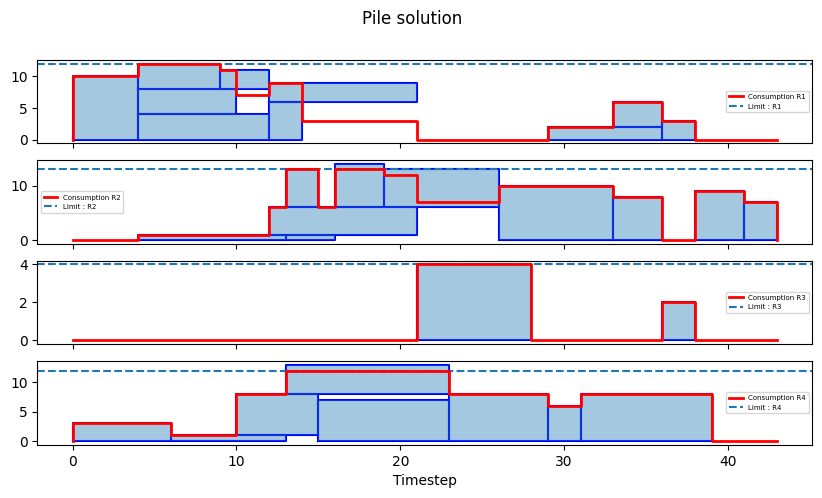

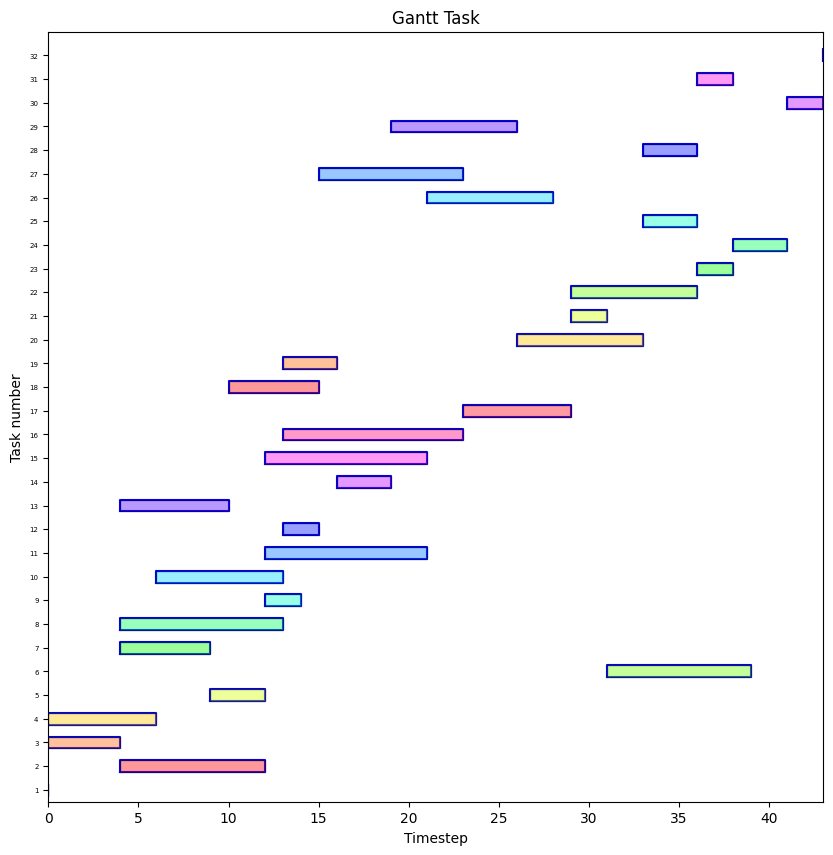

In [6]:
fig_resource_view = plot_ressource_view(
    rcpsp_model=rcpsp_problem,
    rcpsp_sol=best_solution_greedy,
    title_figure="Pile solution",
)
fig_gantt = plot_task_gantt(
    rcpsp_model=rcpsp_problem,
    rcpsp_sol=best_solution_greedy,
)

We observe that the schedule is quite compact, the resource usage seems hard to improve and we are not that far from the theoretical lower bound of 38, that is the optimal duration of the schedule if there was no resource constraint.

## Heuristic based on critical path computation output : SGS

SGS can be seen as a priority based greedy algorithm, the more the task id is on the left side of the permutation, the more it has chance to be scheduled faster. 
We can therefore build heuristic ordering of the task and run SGS on it. One idea it to reuse output of the CPM algorithm to schedule first the task that have the lowest earliest finish date for example, but you can imagine other rules. Let's rerun the ```CPM``` utility already used in previous notebook. 

In [7]:
solver = CPM(rcpsp_model=rcpsp_problem)
critical_path = solver.run_classic_cpm()
sol = solver.solve().get_best_solution()
sol.get_start_time(rcpsp_problem.sink_task)

c:\Users\Lantek\anaconda3\envs\rcpsp_code_env\lib\site-packages\discrete_optimization\rcpsp\fast_function_rcpsp.py:100: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  minimum_starting_time[permutation_task[j]] = max(


46

In [8]:
print("Available fields in CPM output : ", solver.map_node[1].__dict__.keys())

# list sorted by EFD ?
perm_lfd = sorted(rcpsp_problem.tasks_list, key=lambda x: solver.map_node[x]._LFD)
index_perm_lfd = [
    rcpsp_problem.index_task_non_dummy[i]
    for i in perm_lfd
    if i in rcpsp_problem.index_task_non_dummy
]
sol_lfd = RCPSPSolution(problem=rcpsp_problem, rcpsp_permutation=index_perm_lfd)
perm_lsd = sorted(rcpsp_problem.tasks_list, key=lambda x: solver.map_node[x]._LSD)
index_perm_lsd = [
    rcpsp_problem.index_task_non_dummy[i]
    for i in perm_lsd
    if i in rcpsp_problem.index_task_non_dummy
]
sol_lsd = RCPSPSolution(problem=rcpsp_problem, rcpsp_permutation=index_perm_lsd)
# Try different methods ?
# What would be your best results ?
print("LFD ", rcpsp_problem.evaluate(sol_lfd))
print("LSD ", rcpsp_problem.evaluate(sol_lsd))

sol_lsd = RCPSPSolution(problem=rcpsp_problem, rcpsp_permutation=index_perm_lsd)

Available fields in CPM output :  dict_keys(['_ESD', '_EFD', '_LSD', '_LFD'])
LFD  {'makespan': 49, 'mean_resource_reserve': 0}
LSD  {'makespan': 46, 'mean_resource_reserve': 0}


We let you image better priority rules that could be used, because we are a bit disappointed with the priority list so far :) !